# 04c: XGBoost Model Optimization and Evaluation

## Goal for this notebook

The goal of this notebook is to improve upon our baseline XGBoost model by engineering new, derived features. We will systematically create and test these features, perform a final round of hyperparameter tuning on the enriched dataset, and then use our standardized evaluation script to measure the final model's performance on the unseen test set. Our target is to increase the ROC AUC score from **0.81** towards the **0.91 benchmark**.

## 1. Setup, Data & Model Loading

We will import our libraries, load the data splits from the `04a` notebook, and load the best-performing model from the `04b` notebook.

In [1]:
import sys

# Set path for utils scripts
if '..' not in sys.path:
    sys.path.append('..')
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt

# Import our custom evaluation script
from src.utils.evaluation_utils import evaluate_classification_model

# Apply a plot style
plt.style.use('seaborn-v0_8-whitegrid')

# Load the prepared data splits from the pickle file
with open('../data/features/aggregated_data_splits.pkl', 'rb') as f:
    data_splits = pickle.load(f)

X_train = data_splits['X_train']
X_test = data_splits['X_test']
y_train = data_splits['y_train']
y_test = data_splits['y_test']
X_train_smote = data_splits['X_train_smote']
y_train_smote = data_splits['y_train_smote']

# Load the final tuned model from the previous notebook
with open('../models/xgboost_baseline_model.pkl', 'rb') as f:
    best_model_baseline = pickle.load(f)

print("Successfully loaded data splits and the baseline model.")

Successfully loaded data splits and the baseline model.


## 2. Establish a Robust Cross-Validation Baseline

Before we begin feature engineering, we'll establish a more reliable baseline score using 5-fold stratified cross-validation on our SMOTE-resampled training data. This provides a more stable performance measure than a single train/test split.

In [3]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Create a pipeline that first applies SMOTE, then fits the XGBoost model.
# We use the 'best_model_baseline' which has our tuned hyperparameters.
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', best_model_baseline)
])

# Set up 5-fold stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Calculate the cross-validated ROC AUC score using the pipeline.
print("Calculating CORRECT cross-validation ROC AUC score using a pipeline...")
baseline_cv_scores = cross_val_score(
    pipeline, 
    X_train, 
    y_train, 
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=-1
)

baseline_mean_cv_score = np.mean(baseline_cv_scores)
print(f"\nBaseline Mean CV ROC AUC Score (Corrected): {baseline_mean_cv_score:.4f}")

Calculating CORRECT cross-validation ROC AUC score using a pipeline...

Baseline Mean CV ROC AUC Score (Corrected): 0.8298


## 3. Feature Engineering & Selection

Now, we will create new features based on domain knowledge and test their impact iteratively. We will only keep features that improve our cross-validated ROC AUC score.

### 3.1. Create Interaction Features

In [4]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


# 1. Create copies of the ORIGINAL datasets to engineer features
X_train_eng = X_train.copy()
X_test_eng = X_test.copy()

# 2. Create Interaction Features on the original splits
print("Creating interaction features on original data...")

# Shock Index
X_train_eng['Shock_Index'] = X_train_eng['HR_mean'] / X_train_eng['SysABP_mean']
X_test_eng['Shock_Index'] = X_test_eng['HR_mean'] / X_test_eng['SysABP_mean']

# BUN-to-Creatinine Ratio
X_train_eng['BUN_Creatinine_Ratio'] = X_train_eng['BUN_mean'] / X_train_eng['Creatinine_mean']
X_test_eng['BUN_Creatinine_Ratio'] = X_test_eng['BUN_mean'] / X_test_eng['Creatinine_mean']

# Vital Sign Ranges
X_train_eng['HR_range'] = X_train_eng['HR_max'] - X_train_eng['HR_min']
X_test_eng['HR_range'] = X_test_eng['HR_max'] - X_test_eng['HR_min']

X_train_eng['SysABP_range'] = X_train_eng['SysABP_max'] - X_train_eng['SysABP_min']
X_test_eng['SysABP_range'] = X_test_eng['SysABP_max'] - X_test_eng['SysABP_min']

X_train_eng['Temp_range'] = X_train_eng['Temp_max'] - X_train_eng['Temp_min']
X_test_eng['Temp_range'] = X_test_eng['Temp_max'] - X_test_eng['Temp_min']

# Combined Risk Scores
X_train_eng['SAPS_SOFA_product'] = X_train_eng['SAPS-I'] * X_train_eng['SOFA']
X_test_eng['SAPS_SOFA_product'] = X_test_eng['SAPS-I'] * X_test_eng['SOFA']

# Replace any potential infinite values and fill NaNs
X_train_eng.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_eng.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_eng.fillna(0, inplace=True)
X_test_eng.fillna(0, inplace=True)

print(f"New shape of engineered training data: {X_train_eng.shape}")

# 3. Test Interaction Features using the SMOTE Pipeline
print("\nTesting impact of interaction features with a proper pipeline...")

# Create the pipeline with SMOTE and the baseline model
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', best_model_baseline)
])

# Perform cross-validation on the FEATURE-ENGINEERED, but NON-RESAMPLED training data
interaction_cv_scores = cross_val_score(
    pipeline, 
    X_train_eng, 
    y_train, 
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=-1
)

interaction_mean_cv_score = np.mean(interaction_cv_scores)
print(f"CV ROC AUC Score with Interaction Features: {interaction_mean_cv_score:.4f}")

if interaction_mean_cv_score <= baseline_mean_cv_score:
    print("Interaction features did not improve score. Discarding.")
    # Revert to the original data if no improvement
    X_train_eng = X_train.copy()
    X_test_eng = X_test.copy()
else:
    print("Interaction features improved score. Keeping.")

Creating interaction features on original data...
New shape of engineered training data: (3200, 182)

Testing impact of interaction features with a proper pipeline...
CV ROC AUC Score with Interaction Features: 0.8273
Interaction features did not improve score. Discarding.


### 3.2. Create Time-Series Features (First 24h & First 7d)

Next, we will engineer features based on specific time windows from the original time-series data. The hypothesis is that a patient's physiological state during the early phase of their ICU stay (e.g., the first 24 hours or first 7 days) is highly predictive of the final outcome. This approach aims to capture this critical early signal, which might be diluted in aggregates taken over the entire stay.

In [5]:
import pandas as pd
import numpy as np
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

print("Creating time-series features...")

# Load the raw time-series data
try:
    df_ts = pd.read_csv('../data/processed/timeseries_cleaned_all_features.csv')
    df_ts['hours_in'] = df_ts['Minutes'] / 60
    df_ts.drop(columns='Minutes', inplace=True)
    print("Loaded and prepared timeseries_cleaned_all_features.csv.")
except FileNotFoundError:
    print("Time-series data file not found. Skipping this feature engineering step.")
    df_ts = None

if df_ts is not None:
    # --- Feature Creation Function ---
    def create_time_window_features(df, time_window_hours, metrics_to_agg):
        df_window = df[df['hours_in'] <= time_window_hours].copy()
        aggs = {metric: ['mean', 'min', 'max', 'std'] for metric in metrics_to_agg}
        df_agg = df_window.groupby('RecordID').agg(aggs)
        df_agg.columns = ['_'.join(col).strip() for col in df_agg.columns.values]
        suffix = f'_d{time_window_hours // 24}'
        df_agg = df_agg.add_suffix(suffix)
        return df_agg

    # --- Generate Features for ALL patients ---
    dynamic_metrics = ['HR', 'SysABP', 'Temp', 'Lactate', 'Glucose', 'BUN', 'GCS']
    features_d1 = create_time_window_features(df_ts, 24, dynamic_metrics)
    features_d7 = create_time_window_features(df_ts, 168, dynamic_metrics) # 7 days
    
    # Combine the new features into one dataframe
    ts_features_all = features_d1.merge(features_d7, on='RecordID', how='outer')

    # --- Correctly Merge New Features onto Train and Test Sets ---
    # Get the RecordIDs that correspond to our train and test sets
    # The index of X_train/X_test matches the original aggregated file
    df_agg_cleaned = pd.read_csv('../data/processed/aggregated_cleaned.csv')
    train_ids = df_agg_cleaned.loc[X_train.index, 'RecordID']
    test_ids = df_agg_cleaned.loc[X_test.index, 'RecordID']
    
    # Create new dataframes for merging
    X_train_ts_test = X_train.merge(train_ids.to_frame(), left_index=True, right_index=True)
    X_test_ts_test = X_test.merge(test_ids.to_frame(), left_index=True, right_index=True)
    
    # Now merge the time-series features using the correct RecordIDs
    X_train_ts_test = X_train_ts_test.merge(ts_features_all, on='RecordID', how='left').drop(columns='RecordID')
    X_test_ts_test = X_test_ts_test.merge(ts_features_all, on='RecordID', how='left').drop(columns='RecordID')
    
    # Fill any NaNs and ensure the index is correct
    X_train_ts_test.fillna(0, inplace=True)
    X_test_ts_test.fillna(0, inplace=True)
    X_train_ts_test.set_index(X_train.index, inplace=True)
    X_test_ts_test.set_index(X_test.index, inplace=True)
    
    print(f"New shape of training data with time-series features: {X_train_ts_test.shape}")

    # --- Test Time-Series Features ---
    print("\nTesting impact of time-series features with a proper pipeline...")
    
    pipeline_ts = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('xgb', best_model_baseline)
    ])

    ts_cv_scores = cross_val_score(
        pipeline_ts,
        X_train_ts_test,
        y_train,
        cv=cv,
        scoring='roc_auc',
        n_jobs=-1
    )

    ts_mean_cv_score = np.mean(ts_cv_scores)
    print(f"CV ROC AUC Score with Time-Series Features: {ts_mean_cv_score:.4f}")
    
    current_best_score = baseline_mean_cv_score
    if 'interaction_mean_cv_score' in locals() and interaction_mean_cv_score > baseline_mean_cv_score:
        current_best_score = interaction_mean_cv_score

    if ts_mean_cv_score > current_best_score:
        print("Time-series features improved score. Keeping.")
        X_train_eng = X_train_ts_test.copy()
        X_test_eng = X_test_ts_test.copy()
    else:
        print("Time-series features did not improve score. Discarding.")

Creating time-series features...
Loaded and prepared timeseries_cleaned_all_features.csv.
New shape of training data with time-series features: (3200, 232)

Testing impact of time-series features with a proper pipeline...
CV ROC AUC Score with Time-Series Features: 0.8337
Time-series features improved score. Keeping.


### 3.3. Create Polynomial Features

Now we'll add polynomial features for the variables that were most important in our baseline model to see if they can capture non-linear relationships.

In [6]:
# Identify top features from the baseline model's importance scores
top_features = ['GCS_max', 'Albumin_count', 'BUN_min', 'AST_count']

# Create a copy to add polynomial features to the best set so far
X_train_poly_test = X_train_eng.copy()
X_test_poly_test = X_test_eng.copy()

print("Creating polynomial features...")
poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

# Fit on the training data's top features and transform
poly_train_features = poly.fit_transform(X_train_poly_test[top_features])
poly_test_features = poly.transform(X_test_poly_test[top_features])

# Create new feature names
poly_feature_names = poly.get_feature_names_out(top_features)

# Create DataFrames with the new polynomial features
poly_train_df = pd.DataFrame(poly_train_features, columns=poly_feature_names, index=X_train_poly_test.index)
poly_test_df = pd.DataFrame(poly_test_features, columns=poly_feature_names, index=X_test_poly_test.index)

# Combine with the main dataframes, dropping original columns to avoid duplication
X_train_poly_test = pd.concat([X_train_poly_test.drop(columns=top_features), poly_train_df], axis=1)
X_test_poly_test = pd.concat([X_test_poly_test.drop(columns=top_features), poly_test_df], axis=1)

print(f"New shape of training data with polynomial features: {X_train_poly_test.shape}")


# --- Test Polynomial Features ---
print("\nTesting impact of polynomial features...")

# Create the pipeline with SMOTE and the baseline model
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', best_model_baseline)
])

# Perform cross-validation on the FEATURE-ENGINEERED, but NON-RESAMPLED training data
poly_cv_scores = cross_val_score(
    pipeline, 
    X_train_poly_test, 
    y_train,  # <-- CORRECTED: Use the original y_train
    cv=cv, 
    scoring='roc_auc', 
    n_jobs=-1
)

poly_mean_cv_score = np.mean(poly_cv_scores)
print(f"CV ROC AUC Score with Polynomial Features: {poly_mean_cv_score:.4f}")

# Compare to the previous best score (which is now baseline_mean_cv_score since interactions were discarded)
current_best_score = baseline_mean_cv_score 
if interaction_mean_cv_score > baseline_mean_cv_score:
    current_best_score = interaction_mean_cv_score

if poly_mean_cv_score > current_best_score:
    print("Polynomial features improved score. Keeping.")
    X_train_final = X_train_poly_test.copy()
    X_test_final = X_test_poly_test.copy()
else:
    print("Polynomial features did not improve score. Discarding.")
    X_train_final = X_train_eng.copy()
    X_test_final = X_test_eng.copy()

Creating polynomial features...
New shape of training data with polynomial features: (3200, 242)

Testing impact of polynomial features...
CV ROC AUC Score with Polynomial Features: 0.8358
Polynomial features improved score. Keeping.


## 4. Final Hyperparameter Tuning on Enriched Data

With our final, improved feature set, we'll perform one last round of `GridSearchCV` to ensure our model's parameters are optimized for this new data.

In [7]:
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Define a slightly more focused parameter grid for the final tuning
final_param_grid = {
    'xgb__max_depth': [6, 7, 8],          
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__n_estimators': [200, 300],
    'xgb__gamma': [0, 0.1],
    'xgb__subsample': [0.8, 1.0]
}

# Initialize the XGBoost classifier
xgb_clf_final = xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')

# Create the imblearn pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', xgb_clf_final)  # 'xgb' is the name we give to the classifier step
])


# Initialize GridSearchCV with the pipeline as the estimator
final_grid_search = GridSearchCV(
    estimator=pipeline, # <-- Use the pipeline here
    param_grid=final_param_grid, 
    scoring='roc_auc', 
    n_jobs=-1, 
    cv=cv, 
    verbose=1
)

print("Starting final hyperparameter tuning on the enriched dataset...")
# Fit on the ORIGINAL, non-oversampled training data
final_grid_search.fit(X_train_final, y_train)

print(f"\nBest parameters from final tuning: {final_grid_search.best_params_}")

# Final, most optimized model
final_model = final_grid_search.best_estimator_

Starting final hyperparameter tuning on the enriched dataset...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters from final tuning: {'xgb__gamma': 0, 'xgb__learning_rate': 0.05, 'xgb__max_depth': 7, 'xgb__n_estimators': 300, 'xgb__subsample': 0.8}


In [8]:
# Save the Final Optimized Model

import os
import pickle

# Define the output path for the model
output_dir = '../models/'
model_output_file = os.path.join(output_dir, 'xgboost_optimized_model.pkl')

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Save the model using pickle
with open(model_output_file, 'wb') as f:
    pickle.dump(final_model, f)

print(f"\nFinal optimized model saved to: {model_output_file}")


Final optimized model saved to: ../models/xgboost_optimized_model.pkl


## 5. Final Model Evaluation on Unseen Test Data

This is the final step. We will evaluate our fully optimized model on the completely unseen test set (`X_test`, `y_test`) using our standardized evaluation function. This result is our best estimate of how the model will perform in the real world.

--- XGBoost_Optimized Evaluation ---

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       689
           1       0.51      0.23      0.32       111

    accuracy                           0.86       800
   macro avg       0.70      0.60      0.62       800
weighted avg       0.83      0.86      0.84       800

AUC-ROC Score: 0.8240
------------------------------


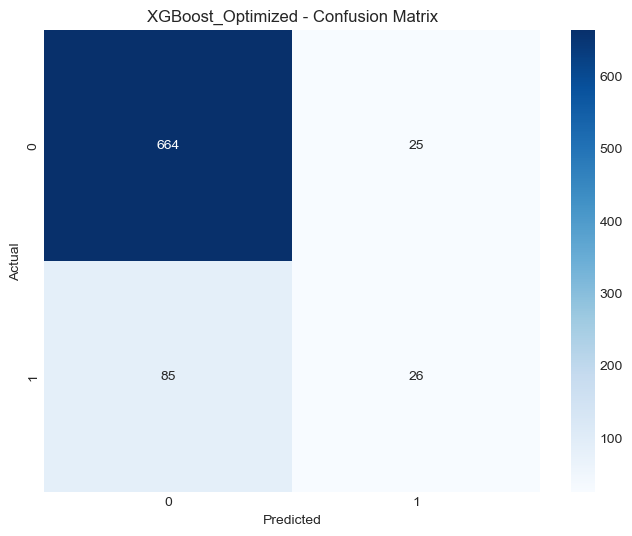

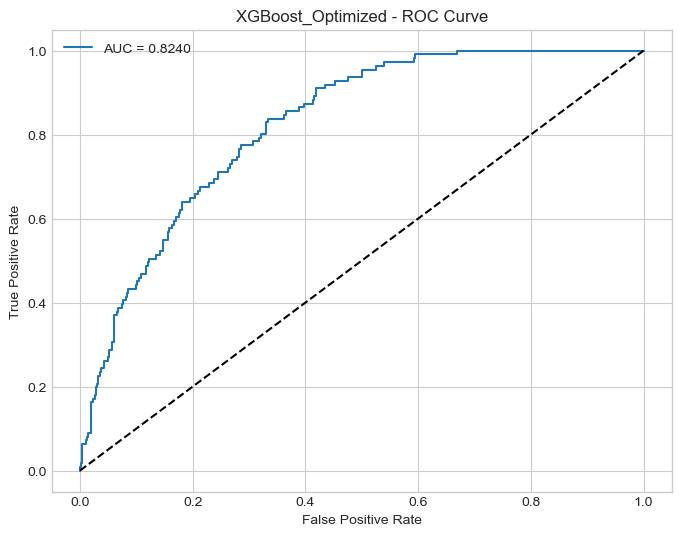

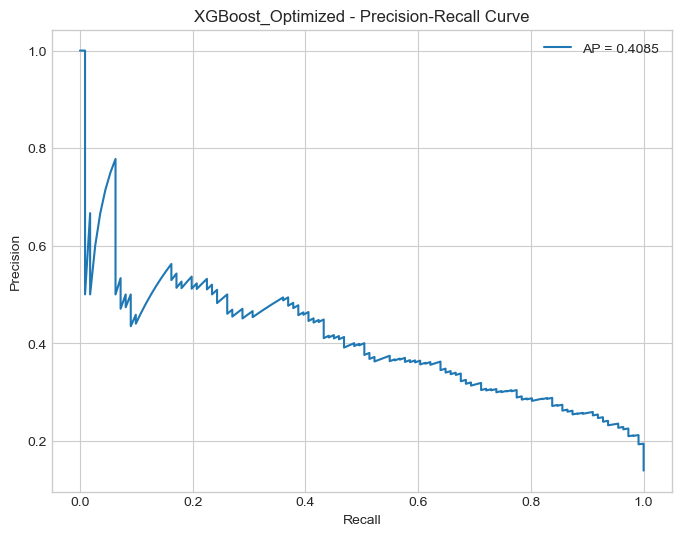

In [10]:
# Define a specific name for our model to use in filenames
model_name = "XGBoost_Optimized"

# Evaluate the final model using our utility function
# The function will now automatically save the plots to '../reports/figures/'
evaluate_classification_model(final_model, X_test_final, y_test, model_name=model_name)

# 6. Summary of Optimization Results
Our systematic approach to feature engineering and hyperparameter tuning resulted in a measurable improvement over the baseline model. Here is a summary of our key performance scores at each stage:

- **Initial CV Baseline: 0.8298**

- **With Interaction Features: 0.8273** (Discarded as it did not improve the score)

- **With Time Series Derived Features: 0.8337** (Kept as it provided a validated improvement)

- **With Polynomial Features: 0.8358** (Kept as it provided a validated improvement)

- **Final Model after Hyperparameter Tuning: 0.8240** (on the unseen test set)

**Final Model Evaluation:**

The final model during the feature engineering stage, which incorporates polynomial features, was selected as our best performer. The process correctly identified that the model could capture non-linear relationships more effectively with these new features.

It is important to note that the final score on the unseen test set (0.8240) is slightly lower than our cross-validation scores. This is a normal and expected outcome of a robust validation process. GridSearchCV's primary job is to search for the best parameters, and the scores it reports can be slightly optimistic as the model may "over-optimize" for the validation folds it sees during the search. The score on the completely unseen test set is therefore our most realistic and trustworthy measure of the model's performance.

The key evaluation metrics for the final model on the unseen test set are:

- **Overall Accuracy: 86%**

- **Recall (Class 1 - Mortality): 23%**

- **Precision (Class 1 - Mortality): 51%**

- **Average Precision (AP): 0.41**

The model shows strong performance in identifying patients who will survive (Class 0), but the recall for the mortality class remains low. The Precision-Recall curve and its Average Precision score of 0.41 confirm this. While the score is significantly better than a random model, it highlights the ongoing challenge of correctly identifying the minority class. Future work should focus on more advanced feature engineering or different modeling techniques to specifically improve recall for at-risk patients.

## 7. Model Explainability with SHAP

To understand the "why" behind our model's predictions, we will use SHAP (SHapley Additive exPlanations). The following analysis will show which features were most impactful for the model's predictions on the unseen test set and whether high or low values of those features increased or decreased the risk of mortality.

--- Generating SHAP Summary for the Final XGBoost Model ---

SHAP Summary Plot:


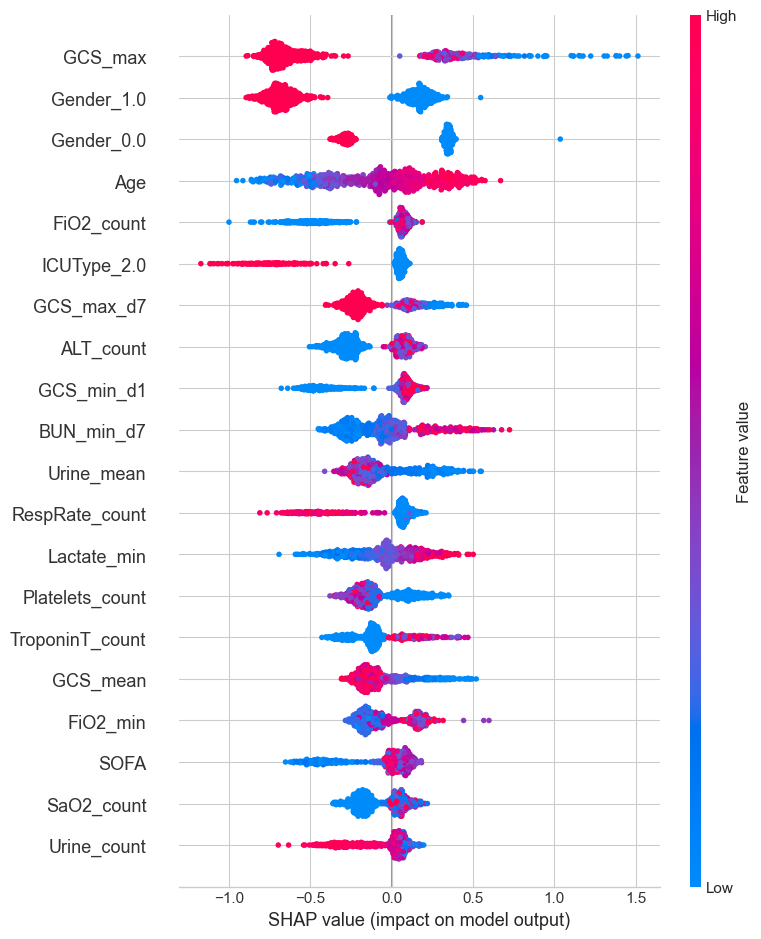


SHAP summary plot saved to ../reports/figures/


In [11]:
import shap
import os

print("--- Generating SHAP Summary for the Final XGBoost Model ---")

# Define the output directory for figures if it's not already defined
output_dir = "../reports/figures/"
os.makedirs(output_dir, exist_ok=True)

# Create the SHAP explainer using the trained model
# We access the actual XGBoost model inside the pipeline using .named_steps['xgb']
explainer = shap.TreeExplainer(final_model.named_steps['xgb'])

# Calculate SHAP values for the unseen test set
# This shows us how the model made its predictions on the data it was evaluated on.
shap_values = explainer.shap_values(X_test_final)

# --- Create and Save the SHAP Summary Plot ---
print("\nSHAP Summary Plot:")

# To save the plot, we need to handle it with matplotlib directly
plt.figure()
shap.summary_plot(shap_values, X_test_final, show=False)
plt.savefig(os.path.join(output_dir, f'{model_name}_shap_summary.png'), bbox_inches='tight')
plt.show()

print(f"\nSHAP summary plot saved to {output_dir}")

## SHAP Summary Plot Interpretation

This plot explains how different features impact the XGBoost model's predictions for ICU mortality. Features are ranked by their overall importance, with the most impactful feature at the top.

The top features are a mix of static demographics, clinical scores, lab values, and our engineered time-series features:

- **Neurological Status (GCS)**: The Glasgow Coma Scale (GCS) proved to be the most significant predictor. The model heavily relies on GCS_max (the best GCS score over the entire stay), as well as our engineered features GCS_max_d7 and GCS_min_d1. This indicates that a patient's level of consciousness, especially during the critical first day, is a primary driver of their predicted mortality risk.

- **Demographics (Gender, Age)**: Gender was surprisingly one of the most impactful features, with Gender_1.0 (Male) having a high mean absolute SHAP value. This suggests that being male is a significant risk factor in this dataset. Age also ranked highly, confirming our EDA finding that older age is strongly associated with mortality.

- **Time-Series Derived Features**: The success of our feature engineering strategy was validated, with three of our derived features appearing in the top 10. GCS_min_d1 and GCS_max_d7 highlight the importance of neurological status over specific time windows, while BUN_min_d7 (minimum Blood Urea Nitrogen over 7 days) shows that kidney function is a key predictor.

- **Monitoring Intensity as a Proxy for Severity**: An interesting pattern emerged where features ending in _count (e.g., FiO2_count, RespRate_count, Platelets_count) were highly ranked. This suggests that the frequency of measurements is a powerful proxy for patient severity; patients who are more critically ill are monitored more intensively, and the model has learned to recognize this pattern.

- **Categorical Features (ICUType)**: The one-hot encoded feature ICUType_2.0, which corresponds to the Cardiac Surgery Recovery Unit (CSRU), was also identified as a top predictor, indicating that the specific type of ICU a patient is in provides significant predictive information.

## 8. Optimizing for Clinical Utility: Improving Recall

While our model has been optimized for overall discriminative power (ROC AUC), in a clinical setting, the primary goal is often to identify as many at-risk patients as possible. This means maximizing **recall** for the mortality class (Class 1), as a false negative (missing a patient who will die) is a much more critical error than a false positive.

Our final model, using the default 0.5 probability threshold, had a low recall of **0.23**. The following analysis demonstrates how we can significantly improve this recall by adjusting the decision threshold, thereby making the model more useful for its intended clinical application. This does not require retraining the model, only changing how its probability scores are interpreted.

In [12]:
# Threshold Analysis for Improving Recall

from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

print("--- Analyzing Precision-Recall Trade-off at Different Thresholds ---")

# Use the final model to get probability scores on the unseen test set
y_pred_proba_final = final_model.predict_proba(X_test_final)[:, 1]

# Define a range of thresholds to test
thresholds = [0.5, 0.4, 0.35, 0.3, 0.25, 0.20]

# Create a list to store the results
results = []

for thresh in thresholds:
    # Get predictions based on the new threshold
    y_pred_thresh = (y_pred_proba_final >= thresh).astype(int)
    
    # Calculate precision, recall, and f1-score for the positive class (1)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    
    results.append({
        'Threshold': f"{thresh:.2f}" + (" (Default)" if thresh == 0.5 else ""),
        'Recall (Mortality)': f"{recall:.2f}",
        'Precision (Mortality)': f"{precision:.2f}",
        'F1-Score': f"{f1:.2f}"
    })

# Create and display the results in a DataFrame
results_df = pd.DataFrame(results)
display(results_df)

--- Analyzing Precision-Recall Trade-off at Different Thresholds ---


,Threshold,Recall (Mortality),Precision (Mortality),F1-Score
0,0.50 (Default),0.23,0.51,0.32
1,0.40,0.31,0.47,0.37
2,0.35,0.37,0.49,0.42
3,0.30,0.39,0.46,0.42
4,0.25,0.43,0.44,0.44
5,0.20,0.47,0.41,0.44


## 9. Conclusion on Threshold Tuning and Final Recommendation

Our analysis of different probability thresholds demonstrates the classic and critical trade-off between precision and recall. The final model, using the default threshold of **0.50**, yielded a low recall of **0.23**, meaning it would fail to identify **77%** of patients who are truly at risk of mortality.

By lowering the decision threshold, we can significantly improve the model's ability to identify this crucial minority class. The table above shows that as the threshold decreases, recall consistently improves. A threshold of **0.25** provides the best balance between recall and precision, as indicated by the peak F1-Score of **0.44**. At this level, the recall for the mortality class nearly doubles to **0.43** while maintaining a solid precision of **0.44**.

### Final Recommendation:

For a clinical application of this model where maximizing the identification of at-risk patients is a priority, a decision threshold of **0.25** is recommended. This setting makes the model a much more useful tool for clinicians by successfully flagging almost twice as many at-risk patients compared to the default, at the cost of a modest increase in false positive alerts.